In [8]:
import os
import itertools


def organize_data(train_dir):
    users = []

    for file in os.listdir(train_dir):
        sign_info = file.split('-')[1]
        users.append(sign_info)

    users_2 = users.copy()
    combinations = itertools.combinations(users_2, 2)
    return combinations

In [9]:
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, Concatenate
from keras.applications import vgg16
from keras.models import Model, Sequential


def build_vgg(input_shape):
    vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                                                 input_shape=input_shape)

    output = vgg.layers[-1].output
    output = Flatten()(output)

    vgg_model = Model(vgg.input, output)
    vgg_model.trainable = False

    for layer in vgg_model.layers:
        layer.trainable = False

    vgg_model.summary()

    vgg_model.trainable = True

    set_trainable = False
    for layer in vgg_model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    return vgg_model


def build_model(input_shape):
    x1 = build_vgg(input_shape)
    x2 = build_vgg(input_shape)

    for layer in x1.layers:
        layer._name = layer._name + str('_1')
    for layer in x2.layers:
        layer._name = layer._name + str('_2')

    merged_model = Concatenate()([x1.output, x2.output])
    merged_model = Dense(units=1024)(merged_model)
    merged_model = BatchNormalization()(merged_model)
    merged_model = Activation('relu')(merged_model)
    merged_model = Dropout(0.5)(merged_model)
    merged_model = Dense(units=1024)(merged_model)
    merged_model = BatchNormalization()(merged_model)
    merged_model = Activation('relu')(merged_model)
    merged_model = Dropout(0.5)(merged_model)
    merged_model = Dense(units=1024)(merged_model)
    merged_model = BatchNormalization()(merged_model)
    merged_model = Activation('relu')(merged_model)
    merged_model = Dropout(0.5)(merged_model)
    merged_model = Dense(units=2, activation='softmax')(merged_model)
    model = Model([x1.input, x2.input], merged_model)

    """
    model = Sequential()
    model.add(vgg_model)
    model.add(Dense(512, activation='relu', input_dim=input_shape))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=2, activation="softmax"))
    """

    return model

In [15]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.utils import to_categorical


train_dir = "./train/"

user_combs = list(organize_data(train_dir))

labels = []
for item in user_combs:
    if item[0][0:3] == item[1][0:3]:
        labels.append(1)
    else:
        labels.append(0)

val_split = 0.2
batch_size = 16
nb_epochs = 1
learning_rate = 1e-6 # 0.001
input_shape = (128, 128, 3)
IMG_DIM = input_shape

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=2, min_lr=0.00001)
callbacks = [reduce_lr]

opt = Adam(learning_rate)
# Shuffle files and labels with the same order.
train_file_list = np.array(user_combs)
labels_list = np.array(labels)

indices = np.arange(train_file_list.shape[0])

np.random.shuffle(indices)

train_file_list = train_file_list[indices]
labels_list = labels_list[indices]

train_length = len(train_file_list)
val_num = int(train_length * val_split)

val_file_list = train_file_list[train_length - val_num: train_length]
val_label_list = labels_list[train_length - val_num: train_length]

val_label_list = to_categorical(val_label_list, 2)

train_file_list = train_file_list[0:train_length - val_num]
labels_list = labels_list[0:train_length - val_num]

labels_list = to_categorical(labels_list, 2)

steps_per_epoch = np.ceil(len(train_file_list)/batch_size)
validation_steps = np.ceil(len(val_file_list)/batch_size)


def load_images(files):
    global IMG_DIM
    global train_dir

    imgs = []

    for file in files:
        img0 = load_img(train_dir + "NFI-" + file[0], target_size=IMG_DIM)
        img0 = img_to_array(img0)
        img0 = img0 / 255

        img1 = load_img(train_dir + "NFI-" + file[1], target_size=IMG_DIM)
        img1 = img_to_array(img1)
        img1 = img1 / 255

        imgs.append([img0, img1])

    return np.array(imgs)


def image_loader(files, labels, batch_size):

    L = len(files)

    # this line is just to make the generator infinite, keras needs that
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = load_images(files[batch_start:limit])
            Y_a = labels[batch_start:limit]

            yield ([X[:,0,:,:,:], X[:,1,:,:,:]],Y_a) # a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size


def val_load_images(files):
    global IMG_DIM
    global train_dir

    imgs = []

    for file in files:
        img0 = load_img(train_dir + "NFI-" + file[0], target_size=IMG_DIM)
        img0 = img_to_array(img0)
        img0 = img0 / 255

        img1 = load_img(train_dir + "NFI-" + file[1], target_size=IMG_DIM)
        img1 = img_to_array(img1)
        img1 = img1 / 255

        imgs.append([img0, img1])

    return np.array(imgs)


def val_image_loader(files, labels, batch_size):

    L = len(files)

    # this line is just to make the generator infinite, keras needs that
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = val_load_images(files[batch_start:limit])
            Y_a = labels[batch_start:limit]

            yield ([X[:,0,:,:,:], X[:,1,:,:,:]],[Y_a]) # a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size


model = build_model(input_shape)

model.load_weights("model.h5")
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["acc"])

model.summary()

history = model.fit_generator(generator=image_loader(train_file_list, labels_list, batch_size),
                              steps_per_epoch=steps_per_epoch, epochs=nb_epochs,
                              validation_data=val_image_loader(val_file_list, val_label_list, batch_size),
                              validation_steps=validation_steps, verbose=1, callbacks=callbacks)

model.save("model.h5")
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("accuracy.png")

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("loss.png")



Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

OSError: ignored

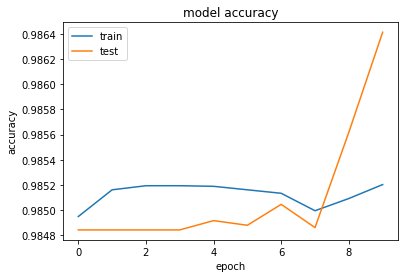

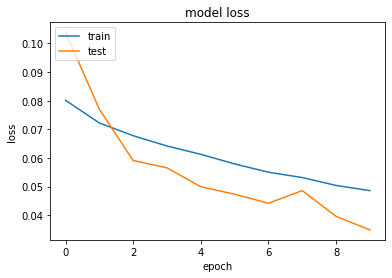

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("accuracy.png")

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("loss.png")


In [ ]:
import pandas as pd

id_info = pd.read_csv("idinfo.csv")

In [ ]:
id_info.head()

,id,person1,imgno1,person2,imgno2
0,1,80,1,80,1
1,2,80,1,80,2
2,3,80,1,80,3
3,4,80,1,80,4
4,5,80,1,80,5


In [ ]:
test_dir = "./test/"
preds = []
for index, row in id_info.iterrows():
    imgs = []

    if row["imgno1"]<10:
      if row["person1"]<100:
        img0 = load_img(test_dir + "NFI-0" + str(row["person1"]) + "0"+
                        str(row["imgno1"]) + "0"+
                        str(row["person1"]) + ".png", target_size=IMG_DIM)
        img0 = img_to_array(img0)
        img0 = img0 / 255
      else:
        img0 = load_img(test_dir + "NFI-" + str(row["person1"]) + "0"+
                        str(row["imgno1"]) +
                        str(row["person1"]) + ".png", target_size=IMG_DIM)
        img0 = img_to_array(img0)
        img0 = img0 / 255
    else:
      if row["person1"]<100:
        img0 = load_img(test_dir + "NFI-0" + str(row["person1"]) +
                        str(row["imgno1"]) + "0"+
                        str(row["person1"]) + ".png", target_size=IMG_DIM)
        img0 = img_to_array(img0)
        img0 = img0 / 255
      else:
        img0 = load_img(test_dir + "NFI-" + str(row["person1"]) +
                        str(row["imgno1"]) +
                        str(row["person1"]) + ".png", target_size=IMG_DIM)
        img0 = img_to_array(img0)
        img0 = img0 / 255
    if row["imgno2"]<10:
      if row["person2"]<100:
        img1 = load_img(test_dir + "NFI-0" + str(row["person2"]) + "0"+
                        str(row["imgno2"]) + "0" +
                        str(row["person2"]) + ".png", target_size=IMG_DIM)
        img1 = img_to_array(img1)
        img1 = img1 / 255
      else:
        img1 = load_img(test_dir + "NFI-" + str(row["person2"]) + "0"+
                        str(row["imgno2"]) +
                        str(row["person2"]) + ".png", target_size=IMG_DIM)
        img1 = img_to_array(img1)
        img1 = img1 / 255
    else:
      if row["person2"]<100:
        img1 = load_img(test_dir + "NFI-0" + str(row["person2"]) +
                        str(row["imgno2"]) + "0" +
                        str(row["person2"]) + ".png", target_size=IMG_DIM)
        img1 = img_to_array(img1)
        img1 = img1 / 255
      else:
        img1 = load_img(test_dir + "NFI-" + str(row["person2"]) +
                        str(row["imgno2"]) +
                        str(row["person2"]) + ".png", target_size=IMG_DIM)
        img1 = img_to_array(img1)
        img1 = img1 / 255
    imgs.append([img0, img1])
    imgs = np.array(imgs)
    
    pred = model.predict([imgs[:,0,:,:,:], imgs[:,1,:,:,:]])
    preds.append(pred)
  
imgs = np.array(imgs)

NameError: ignored

In [ ]:
preds_arr = []

for item in preds:
  preds_arr.append(np.max(item[0]))

preds_arr = np.array(preds_arr)
print(preds_arr.shape)

(41616,)


In [ ]:
ids = []
for i in range(len(preds_arr)):
  ids.append(i+1)

preds_df = pd.DataFrame({'id': ids, 'score': preds_arr})

In [ ]:
print(preds_df.head)
preds_df.to_csv("submit.csv", index=False)

<bound method NDFrame.head of           id     score
0          1  0.796983
1          2  0.905170
2          3  0.914403
3          4  0.968548
4          5  0.894950
...      ...       ...
41611  41612  0.561781
41612  41613  0.566123
41613  41614  0.504597
41614  41615  0.541266
41615  41616  0.619298

[41616 rows x 2 columns]>


In [ ]:
nb_epochs = 3
learning_rate = 1e-5
opt = Adam(learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["acc"])

history = model.fit_generator(generator=image_loader(train_file_list, labels_list, batch_size),
                              steps_per_epoch=steps_per_epoch, epochs=nb_epochs,
                              validation_data=val_image_loader(val_file_list, val_label_list, batch_size),
                              validation_steps=validation_steps, verbose=1, callbacks=callbacks)

model.save("model_2.h5")

Epoch 1/3
13524/13524 [==============================] - 2179s 161ms/step - loss: 0.0433 - acc: 0.9856 - val_loss: 0.0326 - val_acc: 0.9878
Epoch 2/3
13524/13524 [==============================] - 2045s 151ms/step - loss: 0.0419 - acc: 0.9857 - val_loss: 0.0316 - val_acc: 0.9884
Epoch 3/3
13524/13524 [==============================] - 2186s 162ms/step - loss: 0.0410 - acc: 0.9858 - val_loss: 0.0310 - val_acc: 0.9886


RuntimeError: ignored